# Identifying Improper Mask Wear

The goal of this project was to build an image classifier that identifies whether a person is wearing their mask properly or improperly. Images were manually gathered using Google Images. A total of 100 images of proper mask wear and 100 images of improper mask wear were gathered.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, use a smaller *batch size* and try again.

## Looking at the data

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

We are setting a random seed to guarantee that the same validation set is used every time.

In [3]:
path = Path('/storage/masks')

In [4]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=64).normalize(imagenet_stats)

We can first take a look at a random batch of images.

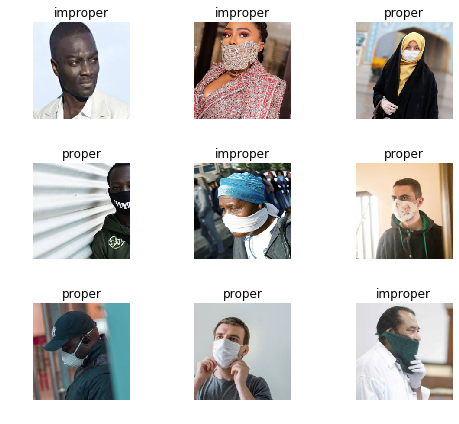

In [5]:
data.show_batch(rows=3, figsize=(7,6))

We can make sure that we have 2 classes, as expected:

In [6]:
print(data.classes)
len(data.classes)

['improper', 'proper']


2

We can then look at a batch of images from the validation and training sets to see if there are large differences between them that might make the model pick up on irrelevant differences other than mask wear.

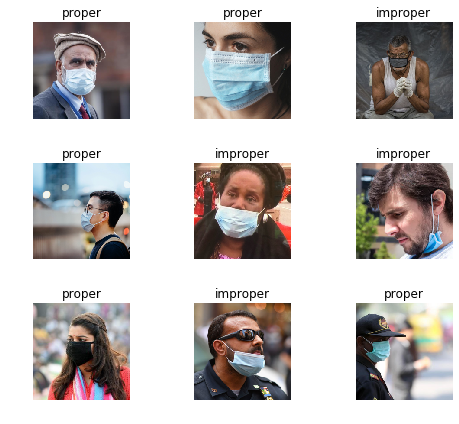

In [7]:
data.show_batch(rows=3, figsize=(7,6), ds_type=DatasetType.Valid)

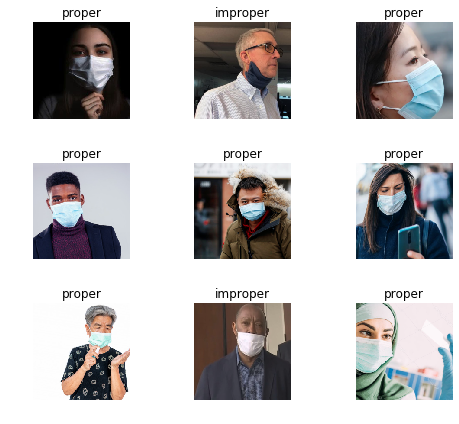

In [8]:
data.show_batch(rows=3, figsize=(7,6), ds_type=DatasetType.Train)

## Training: resnet34

Now we can start training our model. We will use a [convolutional neural network backbone](http://cs231n.github.io/convolutional-networks/) and a fully connected head with a single hidden layer as a classifier. We will be starting off by using the ResNet34 pre-trained weights. The ResNet34 model has already been trained on looking at about one and a half million pictures of all kinds of different things, using an image dataset called ImageNet. 

We will train for 5 epochs.

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.403505,1.212872,0.375000,00:07
1,1.090277,1.487072,0.375000,00:07
2,0.840897,1.425965,0.375000,00:05
3,0.672279,1.144079,0.250000,00:05
4,0.579108,0.878101,0.187500,00:05


The model got an error rate of 0.16 – not too bad. The model will certainly need fine-tuning, but for now we can visualize the results and see which images it was improperly classifying. Before moving on and making changes, we can save our weights:

In [11]:
learn.save('stage-1')

## Visualizing Results

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

We can check the length of our validation set and make sure that the model is being fed with the proper amount of data:

In [13]:
# Checking if validation set used is same length as number of losses calculated
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [14]:
len(data.valid_ds)

32

We can plot the top losses, to find out which things the model was the most wrong on:

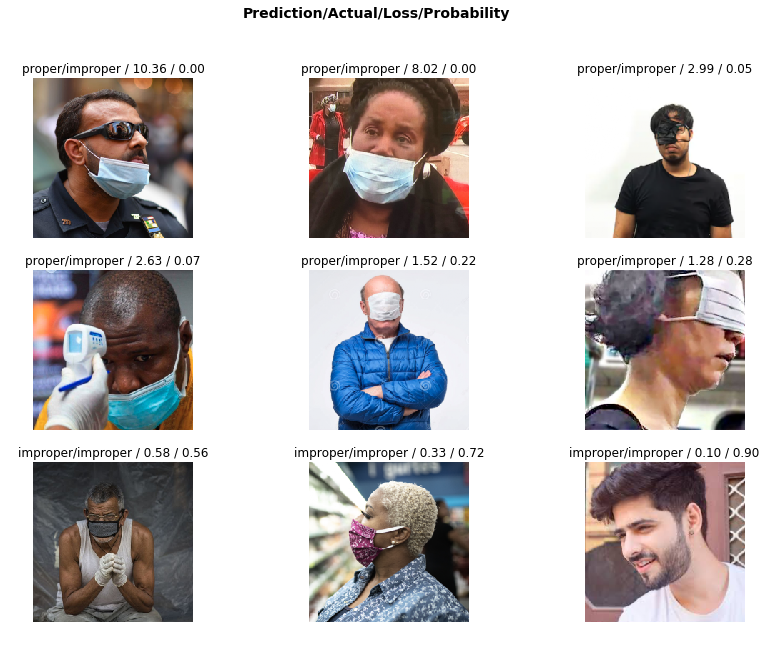

In [15]:
interp.plot_top_losses(9, figsize=(14,10))

There are some very obvious errors. We can plot a confusion matrix and check the pair of classes that were the most confused:

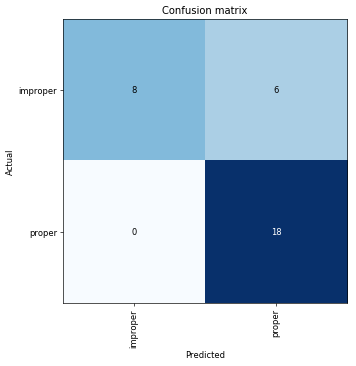

In [16]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [17]:
interp.most_confused()

[('improper', 'proper', 6)]

The model seems to wrongly classify improper mask wear as proper mask wear. It is having a hard time detecting what improper mask wear looks like.

## Unfreezing, fine-tuning, and learning rates

Let's make our model better using fine-tuning. So far we fitted 5 epochs and it ran pretty quickly. The reason it ran pretty quickly is that we used transfer learning and only added a few extra layers to the end, only training those. We basically left most of the model exactly as it was, so that's really fast. If we are trying to build a model at something that's similar to the original pre-trained model (in this case, similar to the ImageNet data), that works pretty well.

But what we really want to do is to go back and train the whole model. This is why we pretty much always use this two stage process. By default, when we call `fit_one_cycle` on a ConvLearner, it'll just fine-tune these few extra layers added to the end and it will run very fast. To get a better accuracy, we have to call `unfreeze`. This will then allow us to train the whole model.

In [18]:
learn.unfreeze()

When trying to retrain all the layers of the model, it seems very unlikely that we can make the first couple of layers' features better. These generally recognize basic features such as diagonal lines, corners, etc. So we don't really want to change the first couple of layers very much if at all. On the other hand, we do want to change the last layers to recognize fine grain details like mask placement. This is why our attempt to fine-tune this model didn't work too well. By default, it trains all the layers at the same speed. 

To resolve this, we can run the learning rate finder. This will figure out what is the fastest we can train this neural network at without making it zip off the rails and get blown apart.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


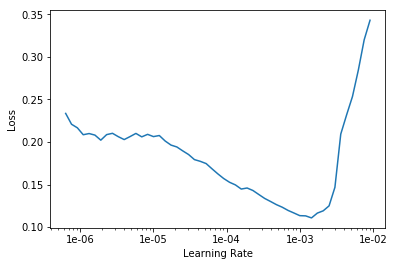

In [19]:
learn.lr_find()
learn.recorder.plot()

The loss seems to get worse and zip off the rails when the learning rate goes past the tipping point of around 3e-03. So based on the learning rate finder, we have to pick something well before the loss starts getting worse. 

We can pass a range of learning rates to `learn.fit_one_cycle`. 

The `slice` keyword says: train the very first layers at a learning rate of 1e-5, and the very last layers at a rate of 3e-4, and distribute all the other layers across that (i.e. between those two values equally).

In [20]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.200640,0.673844,0.187500,00:06
1,0.241225,0.535278,0.125000,00:06
2,0.209211,0.437740,0.093750,00:06
3,0.188128,0.366926,0.093750,00:06
4,0.168655,0.325775,0.093750,00:06


The error rate is getting low. We can save the weights and then try to use pre-trained weights from a deeper network to see if it improves.

In [21]:
learn.save('stage-2')

## Training: resnet152

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet152 (resnet34 is a 34 layer residual network while resnet152 has 152 layers).

Basically, resnet152 usually performs better because it is a much deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's use larger images too, since that way the network can see more detail. We reduce the batch size since this larger network will require more GPU memory.

In [22]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=get_transforms(), size=512, bs=8).normalize(imagenet_stats)

In [23]:
learn = cnn_learner(data, models.resnet152, metrics=error_rate)

In [24]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.988257,0.621946,0.250000,00:26
1,0.893764,0.490162,0.093750,00:21
2,0.692265,0.380395,0.187500,00:21
3,0.541785,0.454429,0.218750,00:23
4,0.409839,0.427870,0.250000,00:15


We can try fine-tuning, but for now we can visualize the results and see which images it was improperly classifying. Before moving on and making changes, we can save our weights:

In [25]:
learn.save('stage-1-152')

## Visualizing Results

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

We can plot the top losses, to find out which things the model was the most wrong on:

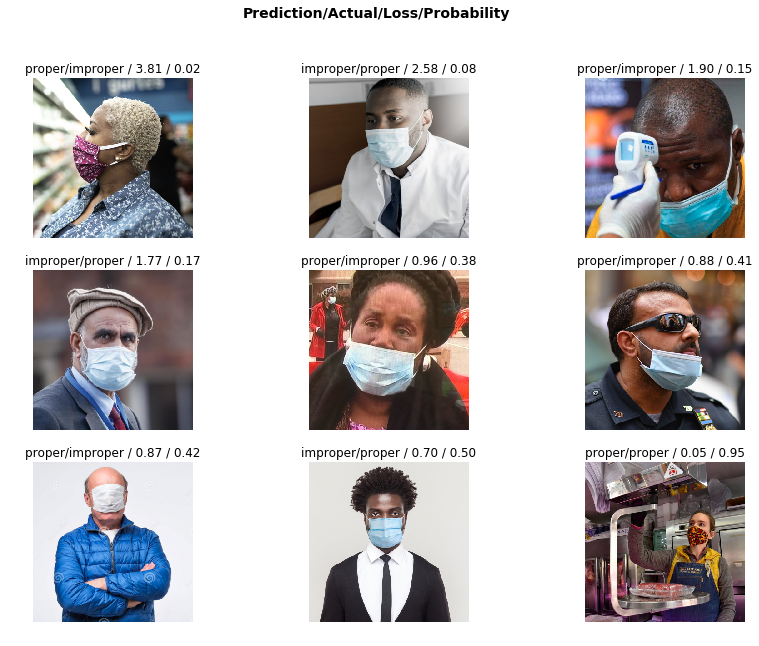

In [27]:
interp.plot_top_losses(9, figsize=(14,10))

The model is making some pretty obvious errors. We can now try fine-tuning.

## Unfreezing and fine-tuning

In [28]:
learn.unfreeze()

We can then run the learning rate finder. This will figure out what is the fastest we can train this neural network at without making it zip off the rails and get blown apart.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


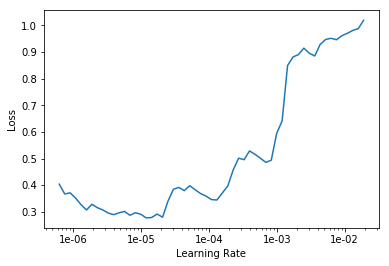

In [31]:
learn.lr_find()
learn.recorder.plot(max_lr=slice(1e-6,1e-3))

The loss seems to get worse and zip off the rails when the learning rate goes past the tipping point of 0.0005. So based on the learning rate finder, we have to pick something well before the loss starts getting worse. 

In [32]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.340997,0.459664,0.218750,00:16
1,0.286633,0.343224,0.156250,00:16
2,0.347697,0.336971,0.187500,00:17
3,0.282823,0.246324,0.156250,00:16
4,0.273207,0.310306,0.156250,00:16


In [33]:
learn.save('stage-2-152')

## Exporting the model

We should pick the better model to export it and deploy it onto a web application.

In [34]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=64).normalize(imagenet_stats)

In [37]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).load('stage-2')

We can train extra epochs:

In [38]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.200331,0.298619,0.125000,00:06
1,0.199976,0.280259,0.093750,00:06
2,0.203263,0.263957,0.093750,00:06
3,0.203712,0.258118,0.093750,00:06
4,0.220492,0.253546,0.093750,00:06


This is the best error rate we've achieved so we can export the model and deploy it.

In [39]:
learn.save('final-model')

In [40]:
learn.export('mask_classification.pkl')